In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Define the ticker symbol for S&P 500
# tickers = ["AAPL", "MSFT", "GOOGL"]
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"]


# Set the end date to today
end_date = datetime.today().strftime('%Y-%m-%d')

# Set the start date to one year ago from today
start_date = (datetime.today() - timedelta(weeks=1000)).strftime('%Y-%m-%d') ## worked with 365 days

# Fetch historical data from Yahoo Finance
# sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date).pct_change().fillna(0)
my_data = yf.download(tickers, start=start_date, end=end_date)
my_data = my_data['Close'].dropna()

[*********************100%***********************]  5 of 5 completed


In [5]:
def smoothing(kernel_size,data):
  kernel = np.ones(kernel_size) / kernel_size
  return np.convolve(data, kernel, mode='same')

(array([13879., 14610., 15340., 16071., 16801., 17532., 18262., 18993.,
        19723., 20454.]),
 [Text(13879.0, 0, '2008'),
  Text(14610.0, 0, '2010'),
  Text(15340.0, 0, '2012'),
  Text(16071.0, 0, '2014'),
  Text(16801.0, 0, '2016'),
  Text(17532.0, 0, '2018'),
  Text(18262.0, 0, '2020'),
  Text(18993.0, 0, '2022'),
  Text(19723.0, 0, '2024'),
  Text(20454.0, 0, '2026')])

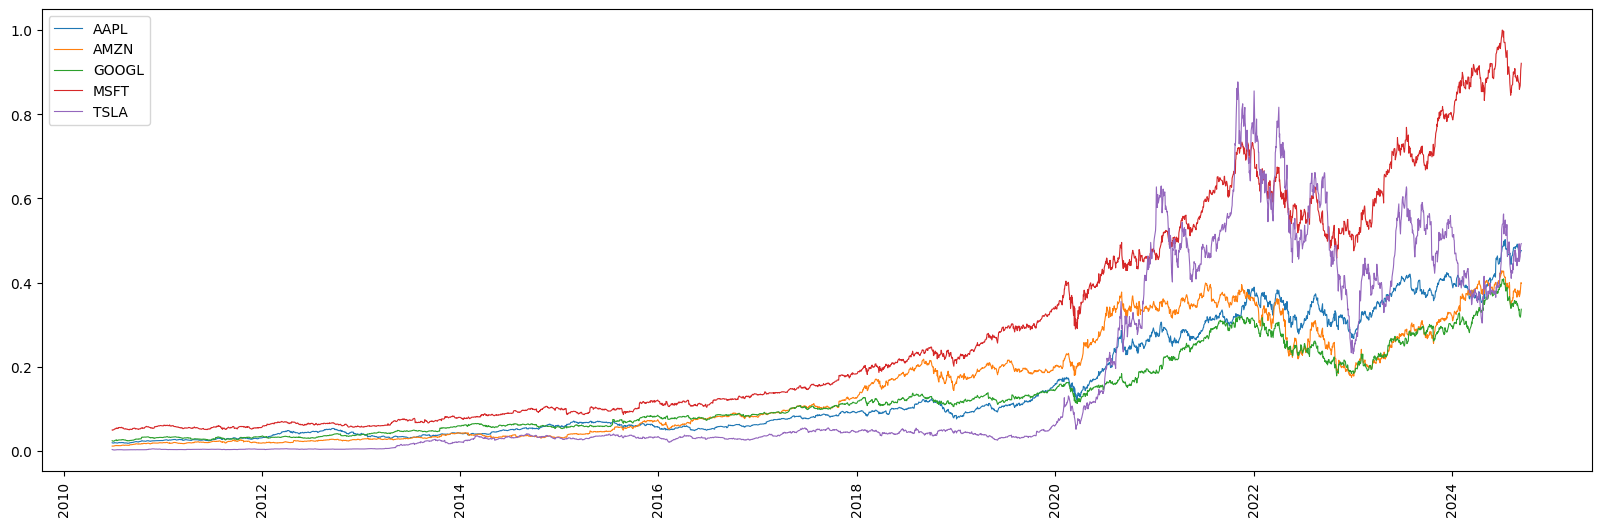

In [6]:
dates_list = my_data[tickers[0]].index.tolist()

# plt.plot(sp500_data.index,close_prices_list, linewidth = 0.8)
# plt.plot(sp500_data.index,smoothing(100,close_prices_list), linewidth = 0.8)
# plt.xticks(rotation=90)

## dataset creation
p = len(dates_list)
N =  len(my_data.columns)
fig = plt.figure(figsize =(20,6))
x, y = np.linspace(0.0, p/10,p), (my_data/np.max(my_data)).to_numpy()
# x, y = np.linspace(0.0, n/10,n), np.nan_to_num(sp500_data['Close'].pct_change().tolist())
plt.plot(my_data.index, y, linewidth = 0.8)
plt.legend(my_data.columns)
plt.xticks(rotation=90)

In [44]:
#### data set 2: (n+1)th pt given n first points in a time series.
def make_next_data2(time_series,n, ndata, dn=1):
  '''times_series is a np 1D array, n-1 number of input points, dn space between them? Produces dataset with length ndata.
  For each window of input+output, substract the value before to normalise the data. first returned array is to get back the original normalisation later.'''
  # l = len(time_series)-dn*n-1
  # return np.array([[time_series[1+i*(l//ndata)+j*dn-1] for j in range(n)] for i in range(ndata)]), np.array([[time_series[1+i*(l//ndata)+j*dn]-time_series[1+i*(l//ndata)+j*dn-1] for j in range(n)] for i in range(ndata)])
  l = len(time_series)-dn*n-dn
  return np.array([[time_series[dn+i*(l//ndata)+j*dn-dn,:] for j in range(n)] for i in range(ndata)]), np.array([[time_series[dn+i*(l//ndata)+j*dn,:]-time_series[dn+i*(l//ndata)+j*dn-dn,:] for j in range(n)] for i in range(ndata)])
n = 10 ##>=2
recover_data, data2 = make_next_data2(y,n,1000,1)
x2, y2 = data2[:,:-1,:], data2[:,-1,:]
recover_x2, recover_y2 = recover_data[:,:-1,:], recover_data[:,-1,:]

x2_og_shape= x2.shape
x2 = np.reshape(x2,(x2_og_shape[0],x2_og_shape[1]*x2_og_shape[2])) 
## It seems to get worse when increasing dn (that might be different with a different asset trend...)
## changing n doesn't seem to change much (might change with multiple assests...)

# Normal NN

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=.25, shuffle=False)

X2 = torch.tensor(X_train, dtype=torch.float32)
Y2 = torch.tensor(y_train, dtype=torch.float32).reshape(-1, N)  # updated to match y2's new shape
X2_test = torch.tensor(X_test, dtype=torch.float32)
Y2_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, N)  # updated to match y2's new shape

# define the model
n_per_layer = 7 # times input size
n_hidden_layers = 7

######## NN ##########
layers = []
input_size = x2.shape[1]  # updated input size
output_size = y2.shape[1]  # updated output size

layers.append(nn.Linear(input_size, n_per_layer*input_size))  # updated input dimension
layers.append(nn.ReLU())
for i in range(n_hidden_layers):
    layers.append(nn.Linear(n_per_layer*input_size, n_per_layer*input_size))
    layers.append(nn.ReLU())
layers.append(nn.Linear(n_per_layer*input_size, output_size))  # updated output dimension
layers.append(nn.Sigmoid())
model = nn.Sequential(*layers)
print(model)

#####################


# train the model
loss_fn   = nn.MSELoss() # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 100

for epoch in range(n_epochs):
    for i in range(0, len(X2), batch_size):
        Xbatch = X2[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y2[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # print(f'Finished epoch {epoch}, latest loss {loss}')

# compute accuracy (no_grad is optional)
#
#     y_pred = model(X2)
with torch.no_grad():
  Y2_pred = model(X2_test)
  Y2_pred_training = model(X2)


Sequential(
  (0): Linear(in_features=9, out_features=63, bias=True)
  (1): ReLU()
  (2): Linear(in_features=63, out_features=63, bias=True)
  (3): ReLU()
  (4): Linear(in_features=63, out_features=63, bias=True)
  (5): ReLU()
  (6): Linear(in_features=63, out_features=63, bias=True)
  (7): ReLU()
  (8): Linear(in_features=63, out_features=63, bias=True)
  (9): ReLU()
  (10): Linear(in_features=63, out_features=63, bias=True)
  (11): ReLU()
  (12): Linear(in_features=63, out_features=63, bias=True)
  (13): ReLU()
  (14): Linear(in_features=63, out_features=63, bias=True)
  (15): ReLU()
  (16): Linear(in_features=63, out_features=5, bias=True)
  (17): Sigmoid()
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x45 and 9x63)

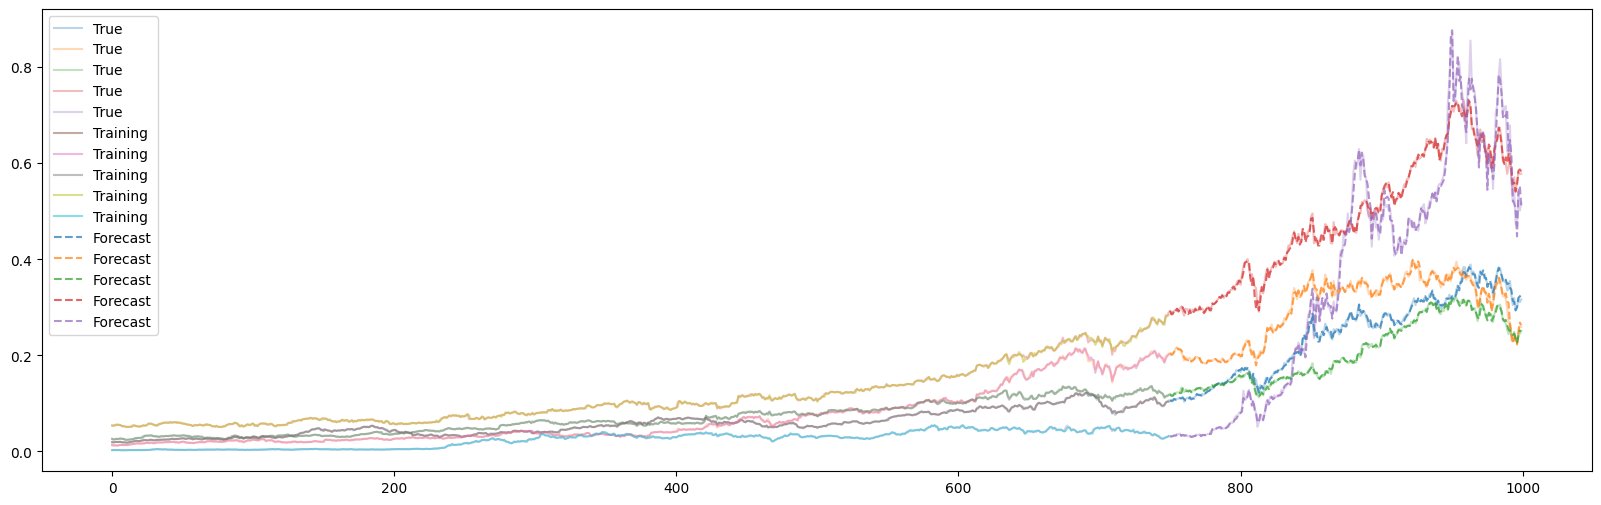

In [38]:
fig = plt.figure(figsize=(20,6))
# plt.plot(y2)
full_y_series = recover_y2+y2
plt.plot(full_y_series,alpha=0.3)
recover_X_train, recover_X_test, recover_y_train, recover_y_test = train_test_split(recover_x2, recover_y2, test_size=.25, shuffle=False)
full_trained_series = recover_y_train+ Y2_pred_training.numpy()
plt.plot(full_trained_series,alpha = 0.5)
full_pred_series = recover_y_test+Y2_pred.numpy()
n1,n2 = len(y2), len(Y2_pred_training)
plt.plot(range(n2,n1),full_pred_series,alpha = 0.7, linestyle='--')
plt.legend(['True']*N+['Training']*N+['Forecast']*N)

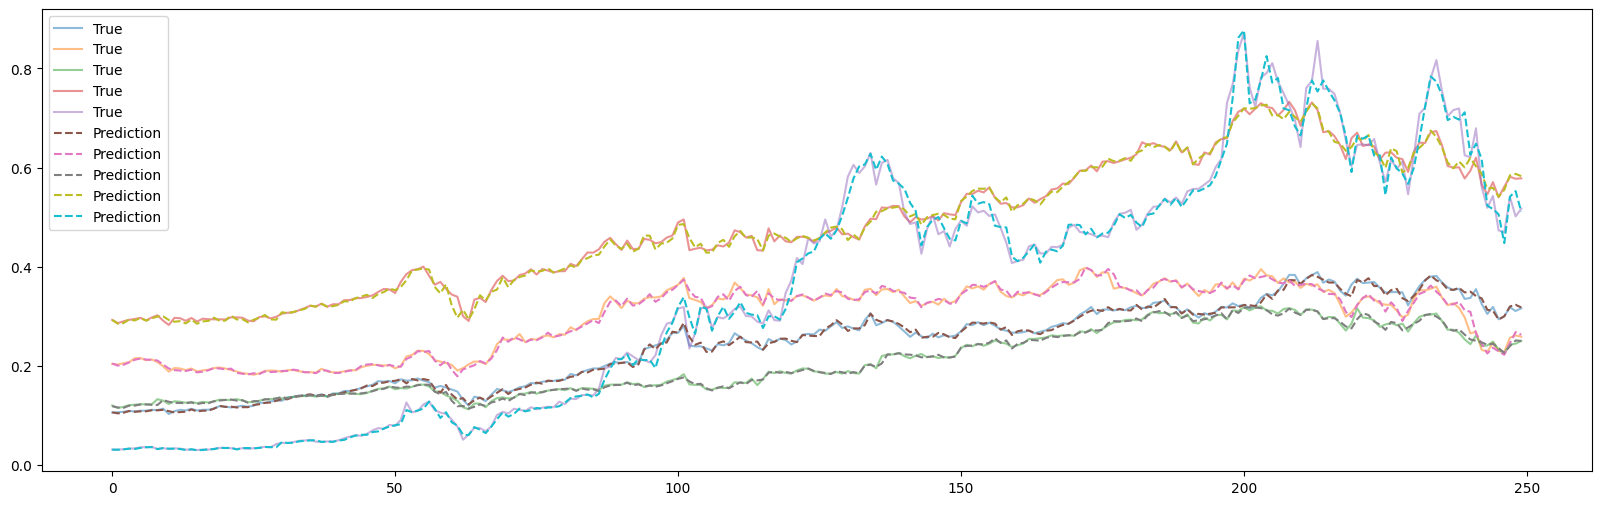

In [39]:
fig = plt.figure(figsize=(20,6))
full_test_true_y_series = recover_y_test+Y2_test.numpy()
plt.plot(full_test_true_y_series,alpha = 0.5)
plt.plot(full_pred_series, linestyle='--')
plt.legend(['True']*N+['Prediction']*N)

Text(0, 0.5, 'Cumulative returns (%)')

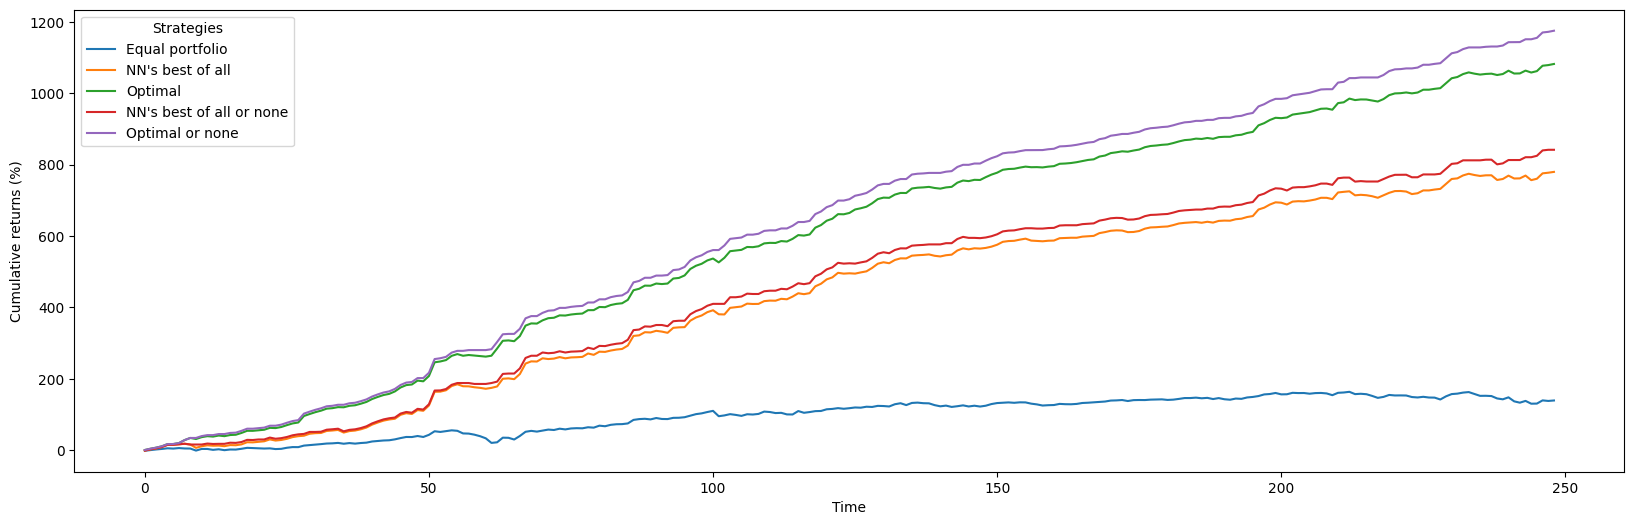

In [40]:
#### Return of the asset vs return on-off if up or down prediction.

# Calculate percentage change
def pctc(arr):
  return np.diff(arr,axis = 0) / arr[:-1,:] * 100

PCa = pctc(full_test_true_y_series)
# PCb = np.copy(PCa)
# PCmax = np.copy(PCa)

temp = pctc(full_pred_series)
# PCb[temp<=0] = 0 # our prediction might tell us when to sell/buy (each time there is a increase/decrease pred)
# PCmax[PCa<=0] =0 # can't get more returns than when knowing the real time-series values and selling when decrease incoming.
PCmax = np.maximum.reduce(PCa,axis=1)
PCmaxBis = np.maximum(PCmax,0.0)


max_indices = np.argmax(temp, axis=1)

# PCb = PCa[:,max_indices]
PCb = PCa[np.arange(PCa.shape[0]), max_indices]

temp  = np.hstack((temp,np.zeros((temp.shape[0], 1))))
max_indices_with_zero = np.argmax(temp, axis=1)
PCa_and_cash = np.hstack((PCa,np.zeros((PCa.shape[0], 1))))

PCbBis = PCa_and_cash[np.arange(PCa_and_cash.shape[0]), max_indices_with_zero]

PCequal = np.sum(PCa,axis = 1)/len(PCa[0]) #if just having the same amount of each asset.

# cumulate the pct changes
PCequal = PCequal.cumsum()
PCb = PCb.cumsum()
PCmax = PCmax.cumsum()
PCbBis = PCbBis.cumsum()
PCmaxBis = PCmaxBis.cumsum()

# Plot
fig = plt.figure(figsize=(20,6))
plt.plot(PCequal)
plt.plot(PCb)
plt.plot(PCmax)
plt.plot(PCbBis)
plt.plot(PCmaxBis)
plt.legend(['Equal portfolio',"NN's best of all",'Optimal', "NN's best of all or none", 'Optimal or none'], title = 'Strategies')
plt.xlabel('Time')
plt.ylabel('Cumulative returns (%)')